In [1]:
import torch
import timm
m = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='')
print(m.pretrained_cfg)
o = m(torch.randn(2, 3, 224, 224))
print(f'Unpooled shape: {o.shape}')

B, C, W, H = o.shape

C:\Users\ProPlayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth', 'hf_hub_id': 'timm/efficientnet_b0.ra_in1k', 'architecture': 'efficientnet_b0', 'tag': 'ra_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.875, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'conv_stem', 'classifier': 'classifier'}
Unpooled shape: torch.Size([2, 1280, 7, 7])


In [2]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'vit_base_patch16_224.augreg2_in21k_ft_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

o = torch.rand((2, 3, 224, 224))

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)

print(data_config)

transforms = timm.data.create_transform(**data_config, is_training=False)

print(transforms)

output = model(o)  # output is (batch_size, num_features) shaped tensor
print(output.shape)
print(transforms(img).shape)
# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 197, 768) shaped tensor

print(output[0, 0, :10])

output = model.forward_head(transforms(img), pre_logits=True)
# output is a (1, num_features) shaped tensor

print(output[0, :10])

{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.9, 'crop_mode': 'center'}
Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)
torch.Size([2, 768])
torch.Size([3, 224, 224])
tensor([ 0.7394,  0.3162, -0.3828, -0.3556, -3.3390, -1.3829, -1.5910, -1.0768,
         0.9661, -1.3756], grad_fn=<SliceBackward0>)
tensor([-0.9686, -0.9843, -0.9843, -0.9686, -0.9608, -0.9765, -0.9608, -0.9686,
        -0.9765, -0.9686])


In [21]:
model = timm.create_model(
    'vit_base_patch16_224.augreg2_in21k_ft_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

print(model.pos_embed.shape)
# print(dir(model))
num_heads = model.blocks[0].attn.num_heads
print(f"Number of attention heads: {num_heads}")  # Output: 12 for vit_base
first_block = model.blocks[0]
input_size = first_block.attn.qkv.in_features
print(f"Input size of the attention layer: {input_size}")
seq_length = model.pos_embed.shape[1]  # Includes CLS token
print(f"Sequence length: {seq_length}")
print(model.cls_token.shape)
# print(model.blocks)

torch.Size([1, 197, 768])
Number of attention heads: 12
Input size of the attention layer: 768
Sequence length: 197
torch.Size([1, 1, 768])


In [22]:
import torch
import timm
from torch import nn

class TemporalViT(nn.Module):
    def __init__(self, num_frames=4):
        super().__init__()
        # Load pretrained ViT (excluding patch embedding)
        self.vit = timm.create_model('vit_base_patch16_224', 
                                   pretrained=True, 
                                   num_classes=0,
                                   in_chans=768)  # Match UNet output dim
                                   
        # Remove original patch embedding (we're using UNet features)
        del self.vit.patch_embed
        
        self.num_frames = num_frames
        self.temporal_pos = nn.Parameter(torch.randn(1, num_frames+1, 768))
        
        # Initialize CLS token from original ViT
        self.cls_token = self.vit.cls_token

    def forward(self, x):
        """Input: [batch_size, num_frames, 768]"""
        batch_size = x.shape[0]
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, 768]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 5, 768]
        
        # Add temporal positional encoding
        x += self.temporal_pos
        
        # Process through ViT
        return self.vit.blocks(x)  # [B, 5, 768]

net = TemporalViT()
t = torch.rand((1, 4, 768))
print(net(t).shape)

torch.Size([1, 5, 768])


In [1]:
from pathlib import Path
from PIL import Image
from IPython.display import display
import pandas as pd

jpeg_p = Path("jpegs_small")
mask_p = Path("masks_small")

df = pd.DataFrame(columns=['masks', 'label'])

X = []
Y = []

dt = 4 # Past images
dl = 1 # Future images to predict

for folder in mask_p.glob("*/*"):
    imgs = list(folder.glob("*"))
    for i in range(len(imgs) - dt - dl + 1):
        # img = imgs[img]
        # print(img)
        # img_mask = mask_p / Path(*img.parts[1:])
        # print(img_mask)
        # display(Image.open(img))
        # display(Image.open(img_mask))
        x = ",".join(str(img) for img in imgs[i: i+dt])
        y = imgs[i + dt + dl - 1]
        X.append(x)
        Y.append(y)

new_row = pd.DataFrame({'masks': X, 'label': Y})    
df = pd.concat([df, new_row], ignore_index=True)
df.to_csv('training.csv', index=False)

inputs


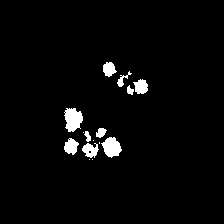

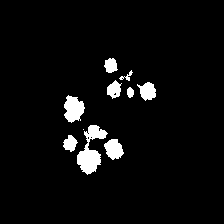

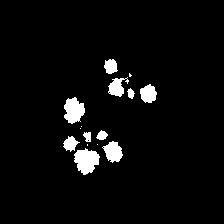

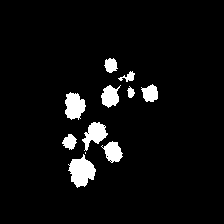

output


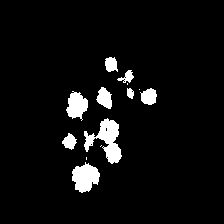

In [2]:
df = pd.read_csv("training.csv")

x, y = df.iloc[40]

print("inputs")
for i in x.split(","):
    display(Image.open(i))

print("output")
display(Image.open(y))



In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import albumentations as a
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('training.csv')


trainval, test = train_test_split(df, random_state=42, test_size=0.2)
train, validation = train_test_split(df, random_state=42, test_size=0.25)

class CustomDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def _load_image(self, path):
        return np.asarray(Image.open(path))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        inputs, label = self.df.iloc[item]
        inputs = [Path(p) for p in inputs.split(",")]
        label = self._load_image(Path(label))
        inputs = [self._load_image(img) for img in inputs]
        # print(np.unique(inputs[0]))
        if self.transforms:
            inputs = [self.transforms(image = img)["image"] / 255 for img in inputs]
            label = self.transforms(image = label)["image"] / 255
        # print(label.squeeze().shape)
        # print(np.unique(label))
        # print(torch.stack(inputs, dim=0).squeeze(1).shape)

        return torch.stack(inputs, dim=0).squeeze(1), label


train_transform = a.Compose([
        a.HorizontalFlip(),
        a.VerticalFlip(),
        a.RandomRotate90(),
        a.Transpose(),
        # a.Normalize(
        #     mean=[0.485, 0.456, 0.406],
        #     std=[0.229, 0.224, 0.225],
        #     max_pixel_value=255
        # ),
        a.ToTensorV2()
    ])

val_transform = a.Compose([
#         a.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#             max_pixel_value=255
#         ),
        a.ToTensorV2()
    ])


ds = CustomDataset(train, train_transform)
test1, test2 = ds[0]

training_ds = CustomDataset(train, train_transform)
test_ds = CustomDataset(test, train_transform)
val_ds = CustomDataset(validation, train_transform)

print(test1.shape)
print(test2.shape)

print(len(training_ds))

NameError: name 'pd' is not defined

In [26]:
df = pd.read_csv('gt.csv')
df = df[(df.label_id == 'ARTVU') & (df.tray_id == 132801)]
print(df['track_id'].unique())

for i in df['track_id'].unique():
    df_ = df[df['track_id'] == i]
    # print(i)
    # print(df_)

[5536 5537 7322 5538 5539 5540 5541]


In [9]:
# Tray id = id of tray
# Label id = class label
# Track id = id of plant instance

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        print(x1.shape)
        x1 = self.up(x1)
        print(x1.shape)

        # # input is CHW
        # diffY = x2.size()[2] - x1.size()[2]
        # diffX = x2.size()[3] - x1.size()[3]

        # x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
        #                 diffY // 2, diffY - diffY // 2])
        # # if you have padding issues, see
        # # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [3]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        print("x4: ", x4.shape)
        print("x5: ", x5.shape)
        x = self.up1(x5, x4)
        print("x:", x.shape)
        # x = self.up2(x, x3)
        # x = self.up3(x, x2)
        # x = self.up4(x, x1)
        # logits = self.outc(x)
        # return logits

In [29]:
net = UNet(1, 2)
test_input = torch.rand((1, 1, 224, 224))

out = net(test_input)
# print(out.shape)

x4:  torch.Size([1, 512, 28, 28])
x5:  torch.Size([1, 1024, 14, 14])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 512, 28, 28])
x: torch.Size([1, 512, 28, 28])


In [30]:
net = UNet(1, 2)
test_input = torch.rand((1, 1, 224, 224))

out = net(test_input)
# print(out.shape)

x4:  torch.Size([1, 512, 28, 28])
x5:  torch.Size([1, 1024, 14, 14])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 512, 28, 28])
x: torch.Size([1, 512, 28, 28])


In [4]:
import torch
import torch.nn as nn


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

# Sanity check
test_input = torch.rand((1, 1, 224, 224))
dc = DoubleConv(1, 2)
print(dc(test_input).shape)


class Downward(nn.Module):
    def __init__(self):
        super(Downward, self).__init__()
        self.conv1 = DoubleConv(1, 16)
        self.conv2 = DoubleConv(16, 32)
        self.conv3 = DoubleConv(32, 64)
        self.conv4 = DoubleConv(64, 128)
        self.maxpool = nn.MaxPool2d(2)
        self.fc = nn.Linear(128*28*28, 768)
        self.features = {}

    def forward(self, x):
        # B, 1, 224, 224
        x = self.conv1(x)
        self.features['conv1'] = x
        # B, 16, 224, 224
        x = self.maxpool(x)
        # B, 16, 112, 112
        x = self.conv2(x)
        self.features['conv2'] = x
        # B, 32, 112, 112
        x = self.maxpool(x)
        # B, 32, 56, 56
        x = self.conv3(x)
        self.features['conv3'] = x
        # B, 64, 56, 56
        x = self.maxpool(x)
        # B, 64, 28, 28
        x = self.conv4(x)
        # B, 128, 28, 28
        B, _, _, _ = x.shape
        return self.fc(x.reshape(B, -1)) # [B, 768]

test_input = torch.rand((6, 1, 224, 224))
dc = Downward()
y = dc(test_input)
print(y.shape)

print(dc.features['conv2'].shape)

torch.Size([1, 2, 224, 224])
torch.Size([6, 768])
torch.Size([6, 32, 112, 112])


In [5]:
class Upward(nn.Module):
    def __init__(self):
        super(Upward, self).__init__()
        self.fc = nn.Linear(768, 128*28*28)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.conv1 = DoubleConv(128, 64)
        self.conv2 = DoubleConv(64, 32)
        self.conv3 = DoubleConv(32, 16)

        self.out = nn.Conv2d(16, 1, kernel_size=3, padding=1, bias=False)

        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, x_res):
        # x_res contains intermediate conv faetures conv1, conv2, conv3
        
        # B, 768
        x = self.fc(x)
        B, _ = x.shape
        x = x.reshape(B, 128, 28, 28)
        # B, 128, 28, 28
        x = self.up1(x)
        # B, 64, 56, 56
        x = torch.cat((x, x_res['conv3']), dim=1)
        # B, 128, 56, 56
        x = self.conv1(x)
        # B, 64, 56, 56
        x = self.up2(x)
        # B, 32, 112, 112
        x = torch.cat((x, x_res['conv2']), dim=1)
        # B, 64, 112, 112
        x = self.conv2(x)
        # B, 32, 112, 112
        x = self.up3(x)
        # B, 16, 224, 224
        x = torch.cat((x, x_res['conv1']), dim=1)
        # B, 32, 224, 224
        x = self.conv3(x)
        # B, 16, 224, 224

        x = self.out(x) # B, 1, 224, 224

        return self.sigmoid(x)

# Sanity check
test = torch.rand((6, 768))
net = Upward()
probs = net(test, dc.features)
y = torch.round(probs)
print(y.shape)
print(torch.unique(y))
to_pil = transforms.ToPILImage()
img = to_pil(y[0, :, :, :].squeeze(0))
display(img)

torch.Size([6, 1, 224, 224])
tensor([0., 1.], grad_fn=<Unique2Backward0>)


NameError: name 'transforms' is not defined

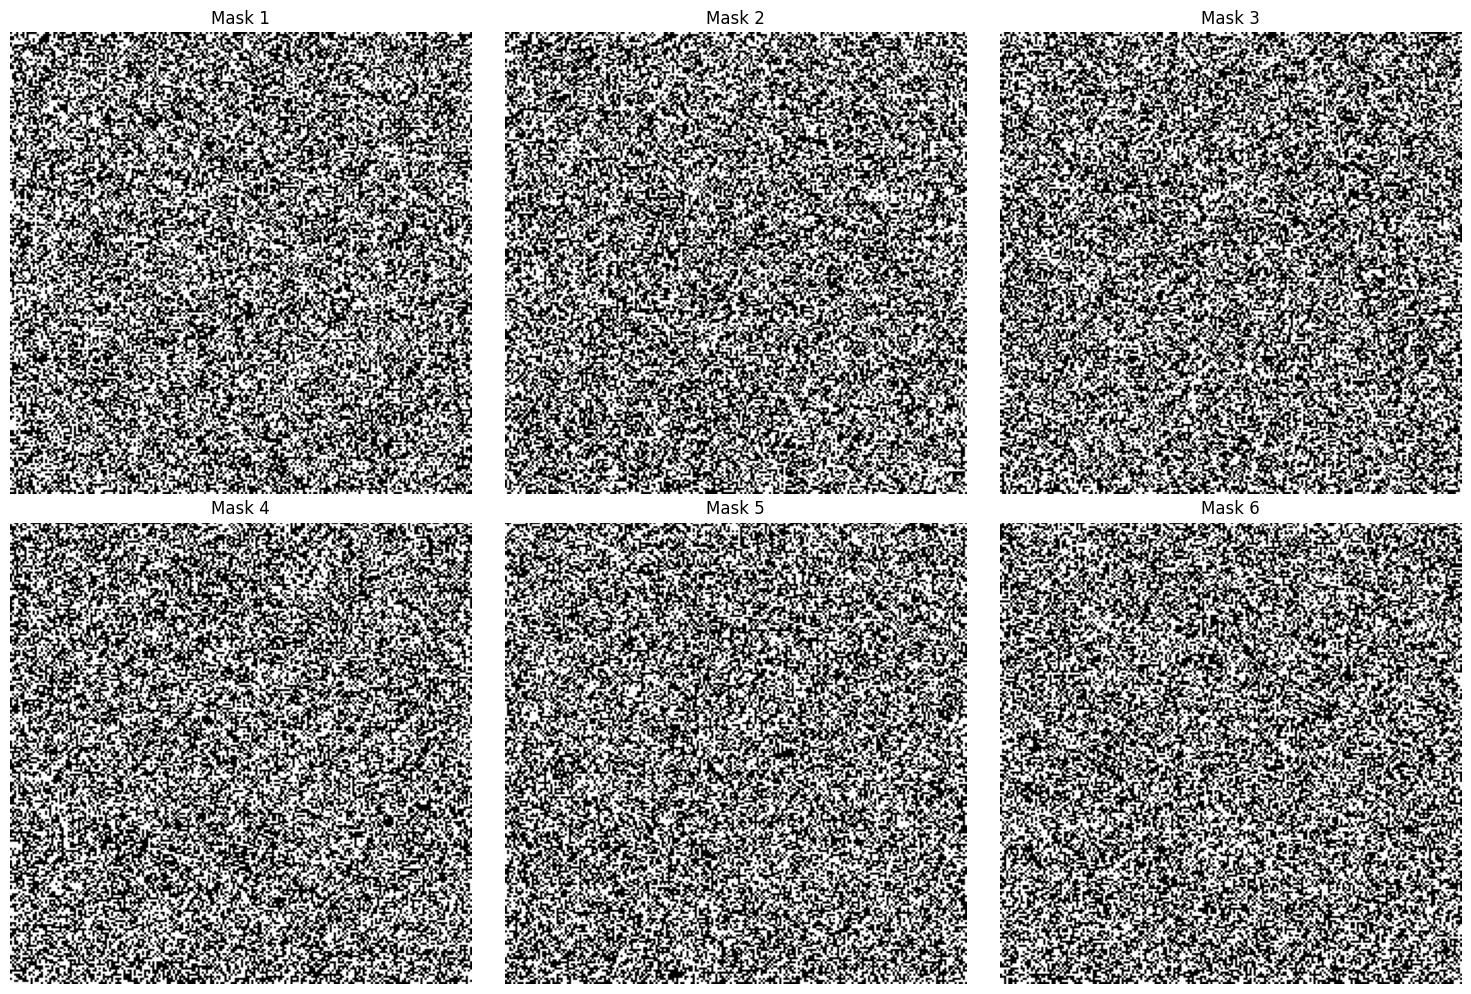

In [33]:
import torch
import matplotlib.pyplot as plt

# Assuming you have a tensor named 'mask' with shape [6, 1, 224, 224]
mask = torch.randn(6, 1, 224, 224) > 0  # Create a random binary mask for demonstration

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Display each mask in the batch
for i in range(6):
    axes[i].imshow(mask[i, 0].numpy(), cmap='gray')
    axes[i].set_title(f'Mask {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
class TestCustomUNet(nn.Module):
    def __init__(self):
        super(TestCustomUNet, self).__init__()
        self.up = Upward()
        self.down = Downward()

    def forward(self, x):
        x = self.down(x)
        x = self.up(x, self.down.features)
        return x

c = TestCustomUNet()
tst = torch.randn(16, 1, 224, 224)
y  = c(tst)
print(y.shape)

torch.Size([16, 1, 224, 224])


In [6]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, x, target):
        B, _, _, _ = x.shape
        intersection = (x * target).sum((2, 3))
        union = x.sum((2, 3)) + target.sum((2, 3)) - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        return 1 - iou.mean()
        

In [1]:
device = 'cuda'

import torch
import torch.nn as nn
import pandas as pd
from torch.optim import AdamW
from tqdm import tqdm

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
# Create a writer to write to Tensorboard
writer = SummaryWriter()

%tensorboard --logdir runs/


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Reusing TensorBoard on port 6006 (pid 20040), started 1 day, 4:20:32 ago. (Use '!kill 20040' to kill it.)

In [7]:
import torch
import timm
from torch import nn

class ViT(nn.Module):
    def __init__(self, num_frames=4):
        super().__init__()
        # Load pretrained ViT (excluding patch embedding)
        self.vit = timm.create_model('vit_base_patch16_224', 
                                   pretrained=True, 
                                   num_classes=0)
                                   
        # Remove original patch embedding (we're using UNet encoder features)
        del self.vit.patch_embed
        
        self.num_frames = num_frames
        self.temporal_pos = nn.Parameter(torch.randn(1, num_frames+1, 768))
        
        # Initialize CLS token from original ViT
        self.cls_token = self.vit.cls_token

    def forward(self, x):
        """Input: [batch_size, num_frames, 768]"""
        batch_size = x.shape[0]
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, 768]
        x = torch.cat((cls_tokens, x), dim=1) # [B, 5, 768]
        
        # Add temporal positional encoding
        x += self.temporal_pos
        
        # Process through ViT
        return self.vit.norm(self.vit.blocks(x))  # [B, 5, 768]

net = ViT()
t = torch.rand((1, 4, 768))
print(net(t).shape)

C:\Users\ProPlayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 5, 768])


In [8]:
class Network(nn.Module):
    def __init__(self, num_frames=4):
        super(Network, self).__init__()
        self.device = device
        self.encoders = nn.ModuleList([
            Downward() 
            for _ in range(num_frames)
        ])
        self.num_frames = num_frames

        self.decoder = Upward()

        self.vit = ViT()

    def forward(self, x):
        x = [self.encoders[i](x[:, i, :, :].unsqueeze(1)) for i in range(self.num_frames)]
        x = torch.stack(x, dim=1)
        x = self.vit(x)
        x = self.decoder(x[:, 0, :], self.encoders[3].features)

        return x
        
            


t = torch.rand((4, 4, 224, 224)).to('cuda')
test = Network().to('cuda')
y = test(t)

In [11]:
from torchsummary import summary

test = Network()
summary(test, (4, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Downward: 2-1                     [-1, 768]                 --
|    |    └─DoubleConv: 3-1              [-1, 16, 224, 224]        2,512
|    |    └─MaxPool2d: 3-2               [-1, 16, 112, 112]        --
|    |    └─DoubleConv: 3-3              [-1, 32, 112, 112]        13,952
|    |    └─MaxPool2d: 3-4               [-1, 32, 56, 56]          --
|    |    └─DoubleConv: 3-5              [-1, 64, 56, 56]          55,552
|    |    └─MaxPool2d: 3-6               [-1, 64, 28, 28]          --
|    |    └─DoubleConv: 3-7              [-1, 128, 28, 28]         221,696
|    |    └─Linear: 3-8                  [-1, 768]                 77,071,104
|    └─Downward: 2-2                     [-1, 768]                 --
|    |    └─DoubleConv: 3-9              [-1, 16, 224, 224]        2,512
|    |    └─MaxPool2d: 3-10              [-1, 16, 112, 112

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Downward: 2-1                     [-1, 768]                 --
|    |    └─DoubleConv: 3-1              [-1, 16, 224, 224]        2,512
|    |    └─MaxPool2d: 3-2               [-1, 16, 112, 112]        --
|    |    └─DoubleConv: 3-3              [-1, 32, 112, 112]        13,952
|    |    └─MaxPool2d: 3-4               [-1, 32, 56, 56]          --
|    |    └─DoubleConv: 3-5              [-1, 64, 56, 56]          55,552
|    |    └─MaxPool2d: 3-6               [-1, 64, 28, 28]          --
|    |    └─DoubleConv: 3-7              [-1, 128, 28, 28]         221,696
|    |    └─Linear: 3-8                  [-1, 768]                 77,071,104
|    └─Downward: 2-2                     [-1, 768]                 --
|    |    └─DoubleConv: 3-9              [-1, 16, 224, 224]        2,512
|    |    └─MaxPool2d: 3-10              [-1, 16, 112, 112

In [12]:
import torch
import torch.nn as nn
import timm


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

class Downward(nn.Module):
    def __init__(self):
        super(Downward, self).__init__()
        self.conv1 = DoubleConv(4, 16)
        self.conv2 = DoubleConv(16, 32)
        self.conv3 = DoubleConv(32, 64)
        self.conv4 = DoubleConv(64, 128)
        self.maxpool = nn.MaxPool2d(2)
        # self.fc = nn.Linear(128*28*28, 768)
        self.features = {}

    def forward(self, x):
        # B, 1, 224, 224
        x = self.conv1(x)
        self.features['conv1'] = x
        # B, 16, 224, 224
        x = self.maxpool(x)
        # B, 16, 112, 112
        x = self.conv2(x)
        self.features['conv2'] = x
        # B, 32, 112, 112
        x = self.maxpool(x)
        # B, 32, 56, 56
        x = self.conv3(x)
        self.features['conv3'] = x
        # B, 64, 56, 56
        x = self.maxpool(x)
        # B, 64, 28, 28
        x = self.conv4(x)
        # B, 128, 28, 28

        # B, _, _, _ = x.shape
        # return self.fc(x.reshape(B, -1)) # [B, 768]
        return x


class Upward(nn.Module):
    def __init__(self):
        super(Upward, self).__init__()
        # self.fc = nn.Linear(768, 128*28*28)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.conv1 = DoubleConv(128, 64)
        self.conv2 = DoubleConv(64, 32)
        self.conv3 = DoubleConv(32, 16)

        self.out = nn.Conv2d(16, 1, kernel_size=3, padding=1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_res):
        # x_res contains intermediate conv faetures conv1, conv2, conv3

        # B, 128, 28, 28
        x = self.up1(x)
        # B, 64, 56, 56
        x = torch.cat((x, x_res['conv3']), dim=1)
        # B, 128, 56, 56
        x = self.conv1(x)
        # B, 64, 56, 56
        x = self.up2(x)
        # B, 32, 112, 112
        x = torch.cat((x, x_res['conv2']), dim=1)
        # B, 64, 112, 112
        x = self.conv2(x)
        # B, 32, 112, 112
        x = self.up3(x)
        # B, 16, 224, 224
        x = torch.cat((x, x_res['conv1']), dim=1)
        # B, 32, 224, 224
        x = self.conv3(x)
        # B, 16, 224, 224

        x = self.out(x)  # B, 1, 224, 224

        return self.sigmoid(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.up = Upward()
        self.down = Downward()

    def forward(self, x):
        x = self.down(x)
        x = self.up(x, self.down.features)
        return x

In [14]:
from torchsummary import summary

test = UNet()
summary(test, (4, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Downward: 1-1                          [-1, 128, 28, 28]         --
|    └─DoubleConv: 2-1                   [-1, 16, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 16, 224, 224]        2,944
|    └─MaxPool2d: 2-2                    [-1, 16, 112, 112]        --
|    └─DoubleConv: 2-3                   [-1, 32, 112, 112]        --
|    |    └─Sequential: 3-2              [-1, 32, 112, 112]        13,952
|    └─MaxPool2d: 2-4                    [-1, 32, 56, 56]          --
|    └─DoubleConv: 2-5                   [-1, 64, 56, 56]          --
|    |    └─Sequential: 3-3              [-1, 64, 56, 56]          55,552
|    └─MaxPool2d: 2-6                    [-1, 64, 28, 28]          --
|    └─DoubleConv: 2-7                   [-1, 128, 28, 28]         --
|    |    └─Sequential: 3-4              [-1, 128, 28, 28]         221,696
├─Upward: 1-2                            [-1, 1, 224, 224]         --

Layer (type:depth-idx)                   Output Shape              Param #
├─Downward: 1-1                          [-1, 128, 28, 28]         --
|    └─DoubleConv: 2-1                   [-1, 16, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 16, 224, 224]        2,944
|    └─MaxPool2d: 2-2                    [-1, 16, 112, 112]        --
|    └─DoubleConv: 2-3                   [-1, 32, 112, 112]        --
|    |    └─Sequential: 3-2              [-1, 32, 112, 112]        13,952
|    └─MaxPool2d: 2-4                    [-1, 32, 56, 56]          --
|    └─DoubleConv: 2-5                   [-1, 64, 56, 56]          --
|    |    └─Sequential: 3-3              [-1, 64, 56, 56]          55,552
|    └─MaxPool2d: 2-6                    [-1, 64, 28, 28]          --
|    └─DoubleConv: 2-7                   [-1, 128, 28, 28]         --
|    |    └─Sequential: 3-4              [-1, 128, 28, 28]         221,696
├─Upward: 1-2                            [-1, 1, 224, 224]         --

In [16]:
import torch
import torch.nn as nn
import timm


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

class Downward(nn.Module):
    def __init__(self):
        super(Downward, self).__init__()
        self.conv1 = DoubleConv(1, 16)
        self.conv2 = DoubleConv(16, 32)
        self.conv3 = DoubleConv(32, 64)
        self.conv4 = DoubleConv(64, 128)
        self.maxpool = nn.MaxPool2d(2)
        # self.fc = nn.Linear(128*28*28, 768)
        self.features = {}

    def forward(self, x):
        # B, 1, 224, 224
        x = self.conv1(x)
        self.features['conv1'] = x
        # B, 16, 224, 224
        x = self.maxpool(x)
        # B, 16, 112, 112
        x = self.conv2(x)
        self.features['conv2'] = x
        # B, 32, 112, 112
        x = self.maxpool(x)
        # B, 32, 56, 56
        x = self.conv3(x)
        self.features['conv3'] = x
        # B, 64, 56, 56
        x = self.maxpool(x)
        # B, 64, 28, 28
        x = self.conv4(x)
        # B, 128, 28, 28

        # B, _, _, _ = x.shape
        # return self.fc(x.reshape(B, -1)) # [B, 768]
        return x


class Upward(nn.Module):
    def __init__(self):
        super(Upward, self).__init__()
        # self.fc = nn.Linear(768, 128*28*28)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.conv1 = DoubleConv(128, 64)
        self.conv2 = DoubleConv(64, 32)
        self.conv3 = DoubleConv(32, 16)

        self.out = nn.Conv2d(16, 1, kernel_size=3, padding=1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_res):
        # x_res contains intermediate conv faetures conv1, conv2, conv3

        # B, 128, 28, 28
        x = self.up1(x)
        # B, 64, 56, 56
        x = torch.cat((x, x_res['conv3']), dim=1)
        # B, 128, 56, 56
        x = self.conv1(x)
        # B, 64, 56, 56
        x = self.up2(x)
        # B, 32, 112, 112
        x = torch.cat((x, x_res['conv2']), dim=1)
        # B, 64, 112, 112
        x = self.conv2(x)
        # B, 32, 112, 112
        x = self.up3(x)
        # B, 16, 224, 224
        x = torch.cat((x, x_res['conv1']), dim=1)
        # B, 32, 224, 224
        x = self.conv3(x)
        # B, 16, 224, 224

        x = self.out(x)  # B, 1, 224, 224

        return self.sigmoid(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.up = Upward()
        self.down = Downward()

    def forward(self, x):
        x = self.down(x)
        x = self.up(x, self.down.features)
        return x

In [19]:
from torchsummary import summary

test = UNet()
summary(test, (1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Downward: 1-1                          [-1, 128, 28, 28]         --
|    └─DoubleConv: 2-1                   [-1, 16, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 16, 224, 224]        2,512
|    └─MaxPool2d: 2-2                    [-1, 16, 112, 112]        --
|    └─DoubleConv: 2-3                   [-1, 32, 112, 112]        --
|    |    └─Sequential: 3-2              [-1, 32, 112, 112]        13,952
|    └─MaxPool2d: 2-4                    [-1, 32, 56, 56]          --
|    └─DoubleConv: 2-5                   [-1, 64, 56, 56]          --
|    |    └─Sequential: 3-3              [-1, 64, 56, 56]          55,552
|    └─MaxPool2d: 2-6                    [-1, 64, 28, 28]          --
|    └─DoubleConv: 2-7                   [-1, 128, 28, 28]         --
|    |    └─Sequential: 3-4              [-1, 128, 28, 28]         221,696
├─Upward: 1-2                            [-1, 1, 224, 224]         --

Layer (type:depth-idx)                   Output Shape              Param #
├─Downward: 1-1                          [-1, 128, 28, 28]         --
|    └─DoubleConv: 2-1                   [-1, 16, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 16, 224, 224]        2,512
|    └─MaxPool2d: 2-2                    [-1, 16, 112, 112]        --
|    └─DoubleConv: 2-3                   [-1, 32, 112, 112]        --
|    |    └─Sequential: 3-2              [-1, 32, 112, 112]        13,952
|    └─MaxPool2d: 2-4                    [-1, 32, 56, 56]          --
|    └─DoubleConv: 2-5                   [-1, 64, 56, 56]          --
|    |    └─Sequential: 3-3              [-1, 64, 56, 56]          55,552
|    └─MaxPool2d: 2-6                    [-1, 64, 28, 28]          --
|    └─DoubleConv: 2-7                   [-1, 128, 28, 28]         --
|    |    └─Sequential: 3-4              [-1, 128, 28, 28]         221,696
├─Upward: 1-2                            [-1, 1, 224, 224]         --

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Create a writer to write to Tensorboard
writer = SummaryWriter()

def train(model, loader, criterion, optimizer):
    model.train()
    avg_loss = 0
    loader = tqdm(enumerate(loader), total=len(loader))
    for idx, (data, target) in loader:
        data = data.to(device).float()
        target = target.to(device).float()
        
        # testing purposes
        # data = data[:, 0, :, :].unsqueeze(1)

        output = model(data)
        
        loss = criterion(output, target)
        # print(loss)
        writer.add_scalars("Loss", {'Train': loss}, idx)
        
        avg_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return avg_loss / len(loader)

print("Loading...")

epochs = 5
criterion = IoULoss().to(device)
lr = 1e-3
# model = TestCustomUNet().to(device)
model = Network().to(device)
optimizer = AdamW(model.parameters(), lr)

dataloader = DataLoader(training_ds, batch_size=8, shuffle=True)

# checkpoint = torch.load('test2.pth')
# model.load_state_dict(checkpoint['model_state'])
# optimizer.load_state_dict(checkpoint['optimizer_state'])

run = 1

print("Starting...")

# for epoch in tqdm(range(epochs)):
#     train_loss = train(model, dataloader, criterion, optimizer)
#     print(f'Train loss epoch {epoch}: {train_loss}')

#     state = dict(model_state=model.state_dict(), optimizer_state=optimizer.state_dict())
#     torch.save(state, f'epoch_{epoch}.pth')

train(model, dataloader, criterion, optimizer)
state = dict(model_state=model.state_dict(), optimizer_state=optimizer.state_dict())
torch.save(state, f'test{run}.pth')
print('Finished Training')
writer.flush()
writer.close()

In [272]:
epochs = 20
criterion = IoULoss().to(device)
model = TestCustomUNet().to(device)
optimizer = AdamW(model.parameters(), lr)
dataloader = DataLoader(training_ds, batch_size=16, shuffle=True)



def _train(model, loader, criterion, optimizer):
    model.train()
    avg_loss = 0
    for data, target in loader:
        data = data.to(device).float()
        target = target.to(device).float()
        
        # testing purposes
        data = data[:, 3, :, :].unsqueeze(1)

        output = model(data)
        
        loss = criterion(output, target)

        # print(loss)
        
        avg_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return avg_loss / len(loader)


checkpoint = torch.load('D:/epoch_39.pth')
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
for epoch in tqdm(range(40, epochs+40)):
    train_loss = _train(model, dataloader, criterion, optimizer)
    print(f'Train loss epoch {epoch}: {train_loss}')

    state = dict(model_state=model.state_dict(), optimizer_state=optimizer.state_dict())
    torch.save(state, f'D:/epoch_{epoch}.pth')

C:\Users\Mao\AppData\Local\Temp\ipykernel_17420\222579820.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('D:/epoch_39.pth')
  0%|              

Train loss epoch 40: 0.7027605772018433


  5%|████                                                                            | 1/20 [06:05<1:55:44, 365.53s/it]

Train loss epoch 41: 0.7023555040359497


 10%|████████                                                                        | 2/20 [10:22<1:30:34, 301.94s/it]

Train loss epoch 42: 0.705945611000061


 15%|████████████                                                                    | 3/20 [15:08<1:23:25, 294.43s/it]

Train loss epoch 43: 0.7044813632965088


 20%|████████████████                                                                | 4/20 [19:45<1:16:38, 287.38s/it]

Train loss epoch 44: 0.7019292712211609


 25%|████████████████████                                                            | 5/20 [23:47<1:07:46, 271.13s/it]

Train loss epoch 45: 0.7075915336608887


 30%|████████████████████████                                                        | 6/20 [28:05<1:02:11, 266.57s/it]

Train loss epoch 46: 0.7013403177261353


 35%|████████████████████████████▋                                                     | 7/20 [32:16<56:41, 261.67s/it]

Train loss epoch 47: 0.706911563873291


 40%|████████████████████████████████▊                                                 | 8/20 [36:44<52:44, 263.67s/it]

Train loss epoch 48: 0.7046185731887817


 45%|████████████████████████████████████▉                                             | 9/20 [41:10<48:28, 264.41s/it]

Train loss epoch 49: 0.7033534646034241


 50%|████████████████████████████████████████▌                                        | 10/20 [44:51<41:48, 250.83s/it]

Train loss epoch 50: 0.7035135626792908


 55%|████████████████████████████████████████████▌                                    | 11/20 [49:01<37:37, 250.79s/it]

Train loss epoch 51: 0.7064685821533203


 60%|████████████████████████████████████████████████▌                                | 12/20 [53:18<33:40, 252.51s/it]

Train loss epoch 52: 0.7019312381744385


 65%|████████████████████████████████████████████████████▋                            | 13/20 [57:42<29:52, 256.11s/it]

Train loss epoch 53: 0.7024749517440796


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:02:10<25:57, 259.64s/it]

Train loss epoch 54: 0.7006314992904663


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:06:06<21:03, 252.67s/it]

Train loss epoch 55: 0.7046212553977966


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:10:12<16:42, 250.57s/it]

Train loss epoch 56: 0.7051999568939209


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:14:31<12:38, 252.97s/it]

Train loss epoch 57: 0.7009339928627014


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:18:10<08:05, 242.85s/it]

Train loss epoch 58: 0.7041031718254089


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:21:46<03:54, 234.84s/it]

Train loss epoch 59: 0.7020782828330994


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:25:27<00:00, 256.37s/it]


tensor([0., 1.], device='cuda:0')


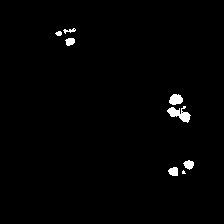

C:\Users\Mao\AppData\Local\Temp\ipykernel_19324\512667697.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('D:/epoch_59.pth')


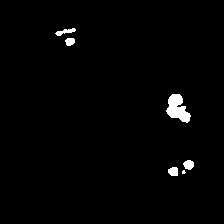

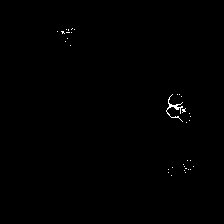

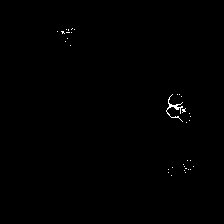

In [58]:
from torchvision import transforms
import random
test_img = val_ds[random.randint(0, len(val_ds) - 1)][1][0].to(device)
print(torch.unique(test_img))
to_pil = transforms.ToPILImage()
img = to_pil(test_img)
display(img)

model = TestCustomUNet().to(device)
model.eval()
checkpoint = torch.load('D:/epoch_59.pth')
model.load_state_dict(checkpoint['model_state'])

prediction = torch.round(model(test_img.unsqueeze(0).unsqueeze(0)).squeeze(0))
# print(torch.unique(prediction))
img = to_pil(prediction)
display(img)

diff = prediction - test_img
img = to_pil(diff)

display(img)

diff_rounded = torch.round(diff)
img = to_pil(diff_rounded)
display(img)

In [ ]:
from dataset import val_ds
import torch
from torchvision import transforms
import random
import model
import matplotlib.pyplot as plt

device = 'cuda'

test_img = val_ds[random.randint(0, len(val_ds) - 1)][0].to(device)
print(test_img.shape)
to_pil = transforms.ToPILImage()
img = to_pil(test_img)
# img.show()

model = model.Network().to(device)
model.eval()
checkpoint = torch.load('epoch_29.pth')
model.load_state_dict(checkpoint['model_state'])

prediction = torch.round(model(test_img.unsqueeze(0)).squeeze(0))
img = to_pil(prediction)
# img.show()

diff = prediction - test_img
img = to_pil(diff)
# img.show()